In [ ]:
# default_exp capture

# Capture

> Helper 

Software simulated camera



In [ ]:
#hide

# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# imitation of Julia's multiple dispatch using @typedispatch
from fastcore.dispatch import typedispatch

# bring forth **kwargs from an inherited class for documentation
from fastcore.meta import delegates

In [ ]:
#export

from fastcore.foundation import patch
from fastcore.meta import delegates
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from PIL import Image
from tqdm import tqdm
import warnings

from typing import Iterable, Union, Callable, List, TypeVar, Generic, Tuple, Optional
import json
import pickle

/Users/eway/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
#export
from openhsi.data import *

/Users/eway/Desktop/openhsi
/Users/eway/Desktop/openhsi/nbs


In [ ]:
#export

@delegates()
class OpenHSI(DataCube):
    """Base Class for the OpenHSI Camera."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        super().set_processing_lvl(self.proc_lvl)
        if callable(getattr(self,"get_temp",None)):
            self.cam_temperatures = CircArrayBuffer(size=(self.n_lines,),dtype=np.float32)
        
    def __enter__(self):
        return self
    
    def __close__(self):
        self.stop_cam()

    def __exit__(self, exc_type, exc_value, traceback):
        self.stop_cam()
        
    def collect(self):
        """Collect the hyperspectral datacube."""
        self.start_cam()
        for i in tqdm(range(self.n_lines)):
            self.put(self.get_img())
            
            if callable(getattr(self,"get_temp",None)):
                self.cam_temperatures.put( self.get_temp() )
        self.stop_cam()
        
    def getNimgs(self, numframes):
        data = np.zeros(tuple(self.settings['resolution'])+(numframes,),np.int32)
        
        self.start_cam()
        for f in range(numframes):
            data[:,:,f]=self.get_img()
        self.stop_cam()
        return data


Running in notebook slow downs. 

In [ ]:
show_doc(OpenHSI.collect)

<h4 id="OpenHSI.collect" class="doc_header"><code>OpenHSI.collect</code><a href="__main__.py#L21" class="source_link" style="float:right">[source]</a></h4>

> <code>OpenHSI.collect</code>()

Collect the hyperspectral datacube.

To add a custom camera, five methods need to be defined in a class to:
1. Initialise camera `__init__`, 
2. Open camera `start_cam`,
3. Close camera `stop_cam`,  and
4. Capture a picture as a numpy array `get_img`.
5. Update the exposure settings `set_exposure`

By inheriting from the `OpenHSI` class, all the methods to load settings/calibration files, collect datacube, saving data to NetCDF, and viewing as RGB are integrated. Furthermore, the custom camera class can be passed to a `SettingsBuilder` class for calibration. 

In [ ]:
# export

@delegates()
class SimulatedCamera(OpenHSI):
    """Add """
    def __init__(self, img_path:str = None, **kwargs):
        """Initialise Simulated Camera"""
        super().__init__(**kwargs)
        
        if img_path is None:
            self.img = np.random.randint(0,255,(*self.settings["resolution"],3))
        else:
            with Image.open(img_path) as img:
                img = img.resize((np.shape(img)[1],self.settings["resolution"][0]))
                self.img = np.array(img)[...,:3]
        
        self.rgb_buff = CircArrayBuffer(self.img.shape,axis=1,dtype=np.uint8)
        self.rgb_buff.data = self.img
        self.rgb_buff.slots_left = 0 # make buffer full
        
        # Precompute the CIE XYZ matching functions to convert RGB values to a pseudo-spectra
        def piecewise_Guass(x,A,μ,σ1,σ2):
            t = (x-μ) / ( σ1 if x < μ else σ2 )
            return A * np.exp( -(t**2)/2 )
        def wavelength2xyz(λ):
            """λ is in nanometers"""
            λ *= 10 # convert to angstroms for the below formulas
            x̅ = piecewise_Guass(λ,  1.056, 5998, 379, 310) + \
                piecewise_Guass(λ,  0.362, 4420, 160, 267) + \
                piecewise_Guass(λ, -0.065, 5011, 204, 262)
            y̅ = piecewise_Guass(λ,  0.821, 5688, 469, 405) + \
                piecewise_Guass(λ,  0.286, 5309, 163, 311)
            z̅ = piecewise_Guass(λ,  1.217, 4370, 118, 360) + \
                piecewise_Guass(λ,  0.681, 4590, 260, 138)
            return np.array([x̅,y̅,z̅])
        self.λs = np.poly1d( np.polyfit(np.arange(len(self.calibration["wavelengths"])),self.calibration["wavelengths"] ,3) )(
                            np.arange(self.settings["resolution"][1]))
        self.xs = np.zeros( (1,len(self.λs)),dtype=np.float32)
        self.ys = self.xs.copy(); self.zs = self.xs.copy()
        for i in range(len(self.xs[0])):
            self.xs[0,i], self.ys[0,i], self.zs[0,i] = wavelength2xyz(self.λs[i])
        
        self.xyz_buff = CircArrayBuffer(self.settings["resolution"],axis=0,dtype=np.int32)
        
    def rgb2xyz_matching_funcs(self, rgb:np.ndarray) -> np.ndarray:
        """convert an RGB value to a pseudo-spectra with the CIE XYZ matching functions."""
        for i in range(rgb.shape[0]):
            self.xyz_buff.put( rgb[i,0]*self.xs + rgb[i,1]*self.ys + rgb[i,2]*self.zs )
        return self.xyz_buff.data
    
    def start_cam(self):
        pass
    
    def stop_cam(self):
        pass
    
    def get_img(self) -> np.ndarray:
        if self.rgb_buff.is_empty():
            self.rgb_buff.slots_left = 0 # make buffer full again
        return self.rgb2xyz_matching_funcs(self.rgb_buff.get())
    
    def exposure(self):
        pass

    def get_temp(self):
        return 20.


In [ ]:
with SimulatedCamera(img_path="../assets/great_hall_slide.png", n_lines=1028, processing_lvl = 3, 
                     json_path="../assets/cam_settings.json",pkl_path="../assets/cam_calibration.pkl") as cam:
    cam.collect()
    fig = cam.show(hist_eq=True)
    
fig

100%|██████████| 1028/1028 [00:23<00:00, 44.06it/s]


:RGB   [x,y]   (R,G,B)

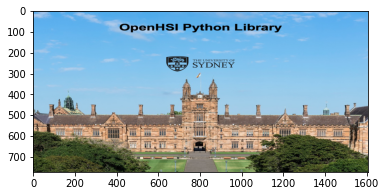

In [ ]:
plt.imshow(cam.rgb_buff.data)

Text(0, 0.5, 'CIE XYZ value')

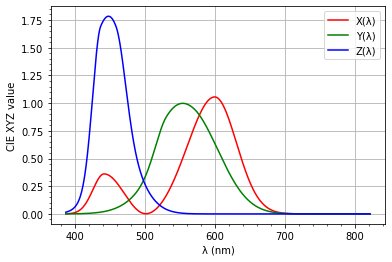

In [ ]:
plt.plot(cam.λs,cam.xs[0],'r',label="X(λ)")
plt.plot(cam.λs,cam.ys[0],'g',label="Y(λ)")
plt.plot(cam.λs,cam.zs[0],'b',label="Z(λ)")
plt.grid(); plt.minorticks_on()
plt.legend()
plt.xlabel("λ (nm)")
plt.ylabel("CIE XYZ value")

In [ ]:
# export

@delegates()
class ProcessDatacube(OpenHSI):
    """Add """
    def __init__(self, fname:str, **kwargs):
        """Process Datacube"""
        super().__init__(**kwargs)
        
        self.fname = fname
        self.buff = DataCube(**kwargs)
        self.buff.load_nc(fname)
        self.buff.dc.slots_left = 0
    
    def start_cam(self):
        pass
    
    def stop_cam(self):
        pass
    
    def get_img(self) -> np.ndarray:
        return self.buff.dc.get()



Below is still experimental stuff

In [ ]:
#external

with ProcessDatacube(fname = "../load_multiple/2021-05-26 03_26_26.011211.nc",n_lines=3072,processing_lvl=-1) as cam:
    cam.collect()
    fig = cam.show(robust=True)
    
fig


  0%|          | 0/3072 [00:00<?, ?it/s]


ValueError: could not broadcast input array from shape (4096,452) into shape (772,2064)

In [ ]:
x = np.zeros((3, 4, 5))
x = np.moveaxis(x, -1, 0)
np.moveaxis(x, 0, -1).shape